In [1]:
!python -V


Python 3.10.13


In [2]:
import pandas as pd


In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [8]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db") 
mlflow.set_experiment("nyc_taxi_experiment")

ModuleNotFoundError: No module named 'mlflow'

In [10]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [11]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

/tmp/ipykernel_3839/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_3839/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


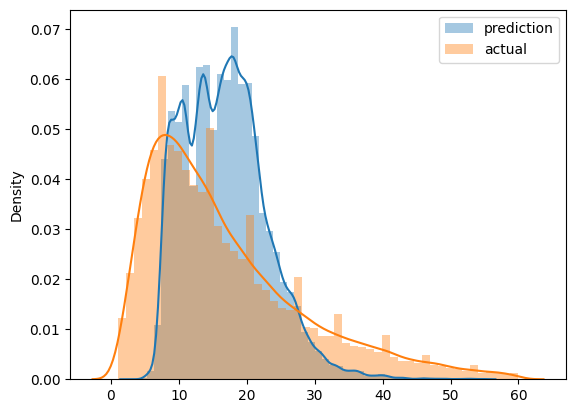

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [15]:
len(df_train), len(df_val)


(73908, 61921)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715209663881

In [20]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():
    mlflow.set_tag("developer","Ibai")
    mlflow.log_param("train_data_path","./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid_data_path","./data/green_tripdata_2021-02.csv")
    alpha=0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
import xgboost as xgb


In [23]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [26]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:25:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.72831                           
[1]	validation-rmse:6.62589                           
[2]	validation-rmse:6.60829                           
[3]	validation-rmse:6.60403                           
[4]	validation-rmse:6.59614                           
[5]	validation-rmse:6.58951                           
[6]	validation-rmse:6.58049                           
[7]	validation-rmse:6.57550                           
[8]	validation-rmse:6.56889                           
[9]	validation-rmse:6.54836                           
[10]	validation-rmse:6.53770                          
[11]	validation-rmse:6.53114                          
[12]	validation-rmse:6.52790                          
[13]	validation-rmse:6.52241                          
[14]	validation-rmse:6.51838                          
[15]	validation-rmse:6.51353                          
[16]	validation-rmse:6.50611                          
[17]	validation-rmse:6.50298                          
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:26:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.32584                                                    
[1]	validation-rmse:7.19546                                                    
[2]	validation-rmse:6.89288                                                    
[3]	validation-rmse:6.79847                                                    
[4]	validation-rmse:6.75783                                                    
[5]	validation-rmse:6.74621                                                    
[6]	validation-rmse:6.73923                                                    
[7]	validation-rmse:6.73359                                                    
[8]	validation-rmse:6.72668                                                    
[9]	validation-rmse:6.72251                                                    
[10]	validation-rmse:6.71746                                                   
[11]	validation-rmse:6.71525                                                   
[12]	validation-rmse:6.71101            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:27:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.09868                                                   
[1]	validation-rmse:7.66481                                                   
[2]	validation-rmse:7.04844                                                   
[3]	validation-rmse:6.78332                                                   
[4]	validation-rmse:6.66299                                                   
[5]	validation-rmse:6.59958                                                   
[6]	validation-rmse:6.56662                                                   
[7]	validation-rmse:6.54598                                                   
[8]	validation-rmse:6.53438                                                   
[9]	validation-rmse:6.52439                                                   
[10]	validation-rmse:6.51951                                                  
[11]	validation-rmse:6.51477                                                  
[12]	validation-rmse:6.51002                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:28:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.02209                                                  
[1]	validation-rmse:8.63402                                                   
[2]	validation-rmse:7.77950                                                   
[3]	validation-rmse:7.27655                                                   
[4]	validation-rmse:6.97361                                                   
[5]	validation-rmse:6.79552                                                   
[6]	validation-rmse:6.68628                                                   
[7]	validation-rmse:6.61795                                                   
[8]	validation-rmse:6.57091                                                   
[9]	validation-rmse:6.54115                                                   
[10]	validation-rmse:6.52068                                                  
[11]	validation-rmse:6.50573                                                  
[12]	validation-rmse:6.49290                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:30:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.59667                                                   
[1]	validation-rmse:8.17907                                                   
[2]	validation-rmse:7.45313                                                   
[3]	validation-rmse:7.08718                                                   
[4]	validation-rmse:6.90235                                                   
[5]	validation-rmse:6.80176                                                   
[6]	validation-rmse:6.74603                                                   
[7]	validation-rmse:6.71149                                                   
[8]	validation-rmse:6.68811                                                   
[9]	validation-rmse:6.67135                                                   
[10]	validation-rmse:6.65802                                                  
[11]	validation-rmse:6.65110                                                  
[12]	validation-rmse:6.64388                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:32:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.76069                                                     
[1]	validation-rmse:8.32411                                                     
[2]	validation-rmse:7.52048                                                     
[3]	validation-rmse:7.07965                                                     
[4]	validation-rmse:6.83943                                                     
[5]	validation-rmse:6.70700                                                     
[6]	validation-rmse:6.62695                                                     
[7]	validation-rmse:6.57919                                                     
[8]	validation-rmse:6.54634                                                     
[9]	validation-rmse:6.52378                                                     
[10]	validation-rmse:6.50790                                                    
[11]	validation-rmse:6.49901                                                    
[12]	validation-rmse:6.49110

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:33:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39570                                                    
[1]	validation-rmse:10.68895                                                    
[2]	validation-rmse:10.07439                                                    
[3]	validation-rmse:9.54833                                                     
[4]	validation-rmse:9.09250                                                     
[5]	validation-rmse:8.70500                                                     
[6]	validation-rmse:8.36851                                                     
[7]	validation-rmse:8.09271                                                     
[8]	validation-rmse:7.85028                                                     
[9]	validation-rmse:7.64855                                                     
[10]	validation-rmse:7.48214                                                    
[11]	validation-rmse:7.33956                                                    
[12]	validation-rmse:7.22137

KeyboardInterrupt: 

In [27]:
mlflow.xgboost.autolog(disable=True)

In [28]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:35:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

KeyboardInterrupt: 

In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

2024/05/27 22:36:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


FileNotFoundError: [Errno 2] No such file or directory: 'models/preprocessor.b'